This notebook is related to the model mentioned in the 5th section of the report, the one which aims at extracting features both from single time series (using 6 heads) and the entire set of them, concatenating results of the previous phase.  

In [17]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

tfk = tf.keras
tfkl = tfk.layers
seed = 100
plt.style.use('ggplot')


In [18]:
X = np.load(f'./augmented/X_stride1.npy')
y = np.load(f'./augmented/y_stride1.npy')

X.shape

(87024, 36, 6)

## Compute weights for classes

In [19]:
counter = np.bincount(y)
frequencies = 1 / counter
weights = frequencies * (y.shape[0] / frequencies.shape[0])

w_s = {}
for i, w in enumerate(weights):
    w_s[i] = w
w_s

{0: 6.099243061396131,
 1: 1.6508081038015026,
 2: 0.7487867836861125,
 3: 0.5300782106571157,
 4: 3.300864815657715,
 5: 1.3250502466654486,
 6: 0.6455977922193537,
 7: 3.0053874844591792,
 8: 1.6924154025670946,
 9: 0.2595840641443247,
 10: 2.649616368286445,
 11: 4.026651860077735}

In [20]:
1 / frequencies

array([ 1189.,  4393.,  9685., 13681.,  2197.,  5473., 11233.,  2413.,
        4285., 27937.,  2737.,  1801.])

In [21]:
def evaluate_model(m, X_val, y_val):
    """
    This method computes the confusion matrix and recall, precision and f1-score for each class.
    :param m: model to evaluate.
    :param X_val: samples to use for the evaluation. X_val cannot be a tf.Dataset object.
    :param y_val: labels for each element of X_val. y_val cannot be a tf.Dataset object.
    :return pandas.DataFrame containing the confusion matrix and pandas.Dataframe whose rows 
    are recall,precision, f1-score and support, whereas columns are the labels.
    """
    y_pred = m.predict(X_val)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_val, axis=1)
    
    c_m = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='true'))
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report = pd.DataFrame(report)
    report = report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    
    return c_m, report

## Split data
loaded data use sliding window with stride 1, this means there are multiple samples sharing the same subset of timestamps. Samples sharing the same subset of timestamp must stay in the same set, otherwise we overfit the validation set and we vanish the help given by the validation set.


In [22]:
df = pd.DataFrame({'y': y})
starting_indexes = list(df.drop_duplicates(keep='first').index.values)
ending_indexes = starting_indexes[1:] + [df.index.values[-1] + 1]

X_train = None
X_val = None

y_train = None
y_val = None

train_percentage = 0.85


for label, starting_index, ending_index in zip(range(12), starting_indexes, ending_indexes):
    
    split_index = int(train_percentage * (ending_index - starting_index))
    split_index += starting_index
    assert split_index + 36 > starting_index
    if X_train is None:
        X_train = X[starting_index: split_index, :, :].copy()
        y_train = y[starting_index: split_index].copy()
        
        X_val = X[split_index + 36: ending_index, :, :].copy()
        y_val = y[split_index + 36: ending_index].copy()
    else:
        X_train = np.append(X_train, X[starting_index: split_index, :, :], axis=0)
        y_train = np.append(y_train, y[starting_index: split_index])
        
        X_val = np.append(X_val, X[split_index + 36: ending_index, :, :], axis=0)
        y_val = np.append(y_val, y[split_index + 36: ending_index])

        
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(73966, 36, 6) (12626, 36, 6) (73966, 12) (12626, 12)


In [23]:
epochs = 300
batch_size = 512
lr = 1e-3

e_s = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    restore_best_weights=True,
    patience=40
)

r_LR = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=15,
    mode='max',
    verbose=1,
    min_lr=1e-5
)


callbacks = [e_s, r_LR]

In [24]:
def build_model(input_shape, n_classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.GaussianDropout(0.05)(input_layer)
    
    #Feature extractor
    convs = []
    for i in range(input_shape[1]):
        t = x[:, :, i]
        t = t[:, :, np.newaxis]
        t = tfkl.Conv1D(128,3,padding='same',activation='relu')(t)
        t = tfkl.MaxPooling1D()(t)
        t = tfkl.Conv1D(128,3,padding='same',activation='relu')(t)
        convs.append(t)
    
    x = tfkl.Concatenate()(convs)
    x = tfkl.Reshape((18, 128, 6))(x)
    x = tfkl.Permute((1, 3, 2))(x)
    x = tfkl.Conv2D(128, (4, 6), padding='same', activation='relu')(x)
    x = tfkl.GlobalAveragePooling2D()(x)
    
    #Fully connected part
    x = tfkl.Dropout(.1, seed=seed)(x)
    x = tfkl.Dense(128, activation='relu')(x)
    
    #Classifier
    output_layer = tfkl.Dense(n_classes, activation='softmax')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    return model

In [25]:
model = build_model(X_train.shape[1:], 12)

categorical_loss = tfk.losses.CategoricalCrossentropy()

model.compile(loss=categorical_loss, optimizer=tfk.optimizers.Adam(learning_rate=lr), metrics='accuracy')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    shuffle=True,
    class_weight=w_s,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/300
145/145 [==============================] - 7s 43ms/step - loss: 1.8934 - accuracy: 0.2544 - val_loss: 1.8336 - val_accuracy: 0.3439
Epoch 2/300
145/145 [==============================] - 6s 42ms/step - loss: 1.3493 - accuracy: 0.3821 - val_loss: 2.0655 - val_accuracy: 0.3775
Epoch 3/300
145/145 [==============================] - 6s 41ms/step - loss: 1.1664 - accuracy: 0.4493 - val_loss: 1.8046 - val_accuracy: 0.3927
Epoch 4/300
145/145 [==============================] - 6s 41ms/step - loss: 1.0542 - accuracy: 0.4858 - val_loss: 1.6456 - val_accuracy: 0.4065
Epoch 5/300
145/145 [==============================] - 6s 41ms/step - loss: 0.9642 - accuracy: 0.5084 - val_loss: 1.5765 - val_accuracy: 0.4554
Epoch 6/300
145/145 [==============================] - 6s 41ms/step - loss: 0.8696 - accuracy: 0.5363 - val_loss: 3.5063 - val_accuracy: 0.3963
Epoch 7/300
145/145 [==============================] - 6s 43ms/step - loss: 0.9938 - accuracy: 0.4999 - val_loss: 1.6797 - val_accuracy:

0.73665452003479
0.9981883764266968


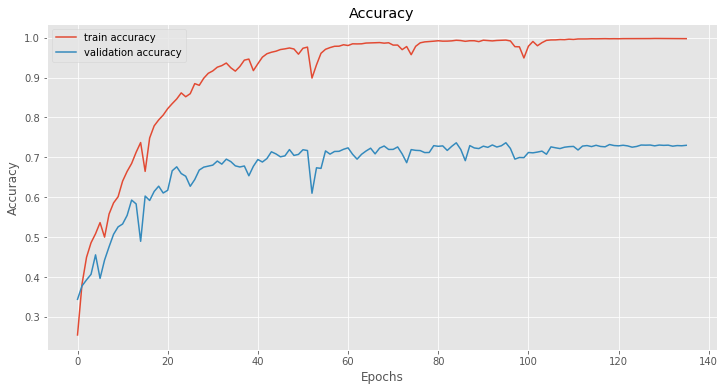

In [26]:
print(np.max(history.history['val_accuracy']))
print(np.max(history.history['accuracy']))
x_axis = np.arange(len(history.history['val_accuracy']))

plt.figure(figsize=(12, 6))
plt.title("Accuracy")
plt.plot(x_axis, history.history["accuracy"], label="train accuracy")
plt.plot(x_axis, history.history["val_accuracy"], label="validation accuracy")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [27]:
c_m, report = evaluate_model(model, X_val, y_val)

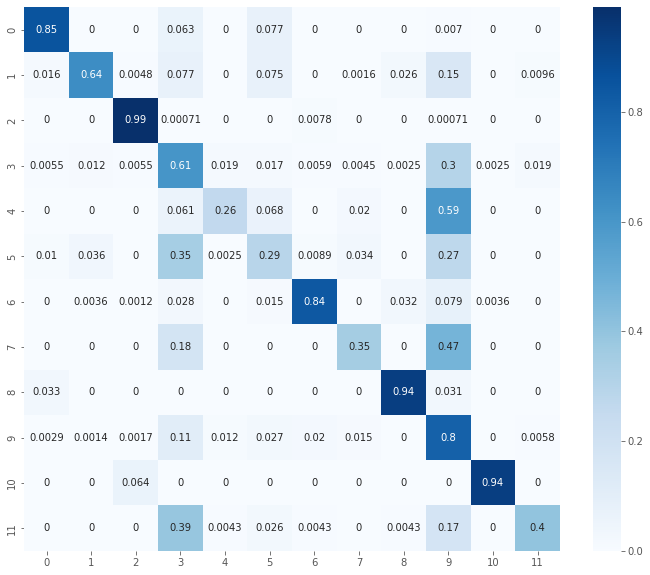

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(c_m, cmap='Blues', annot=True)
plt.show()

In [29]:
report

,0,1,2,3,4,5,6,7,8,9,10,11
precision,0.666667,0.859307,0.967609,0.550067,0.463855,0.473029,0.923077,0.515837,0.883359,0.700272,0.969613,0.576687
recall,0.853147,0.637239,0.990826,0.607338,0.261905,0.290446,0.836871,0.349693,0.935750,0.804091,0.936000,0.400000
f1-score,0.748466,0.731797,0.979079,0.577286,0.334783,0.359905,0.877863,0.416819,0.908800,0.748600,0.952510,0.472362
support,143.000000,623.000000,1417.000000,2017.000000,294.000000,785.000000,1649.000000,326.000000,607.000000,4155.000000,375.000000,235.000000


In [30]:
model.save('models/')